In [1]:
%%capture capt
!pip install scikit-learn-extra
!pip install kneed[plot]

In [2]:
%%capture capt
import numpy as np
from sklearn_extra.cluster import KMedoids
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.metrics import silhouette_score
from matplotlib.ticker import PercentFormatter
import pandas as pd
from tqdm import tqdm
import matplotlib.pyplot as plt
from kneed import KneeLocator
import multiprocessing
from multiprocessing import Pool
import concurrent.futures
import math

# Importation data

In [3]:
base_patient = pd.read_csv("../data/profil_patient.csv")

In [4]:
%%capture capt
p_soins = pd.read_csv("../data/parcours_soins.csv")

In [5]:
p_soins.head(3)

,BEN_NIR_IDT,2008-01-15,2008-02-15,2008-03-15,2008-04-15,2008-05-15,2008-06-15,2008-07-15,2008-08-15,2008-09-15,...,2018-12-19,2018-12-20,2018-12-21,2018-12-22,2018-12-24,2018-12-25,2018-12-26,2018-12-27,2018-12-28,2018-12-29
0,P0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,P6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,P8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [6]:
base_patient.head(3)

,CODE_PATIENT,date_h0,y_nais,BEN_RES_DPT,BEN_SEX_COD,dte_deces,Mort,Nb_survie,Nb_hospit,CHOC,Nb_jours_sej,cat_age,cat_nb_hospit,cat_nb_jours_sej,cluster
0,P0,2011-11-22,1949,11,1,NaN,False,2596,9,False,23,1,1,1,0
1,P6,2013-12-05,1929,14,2,2015-03,True,456,8,False,51,2,1,1,1
2,P8,2015-07-02,1967,54,2,2015-08,True,41,3,True,43,0,1,1,2


# Data Pre-processing

In [7]:
base_patient.Mort = base_patient.Mort.astype(int)
base_patient.CHOC = base_patient.CHOC.astype(int)
base_patient.BEN_SEX_COD = base_patient.BEN_SEX_COD-1

In [8]:
# on ne conserve que l'annee de la premiere hospitalisation

base_patient.date_h0 = pd.to_datetime(base_patient.date_h0).apply(lambda date: int(date.year))

# Vecteur des parcours de GHM

In [9]:
X_patient = []
for i in range(len(base_patient)):
    ghm_row = p_soins.iloc[i].dropna().tolist()[1:]
    X_patient.append(ghm_row)

# Formules de distance entre string

In [10]:
# on importe les fonctions de metriques depuis un autre notebook
%run Metriques.ipynb

Installation/Importation des librairies necessaires.


Tous les GHM ont 6 caractères

In [11]:
def custom_ghm_distance(ghm1, ghm2, distance=string_distance_levenshtein, weights=[50,10,1]):
    return (weights[0]*distance(ghm1[:2], ghm2[:2]) + weights[1]*distance(ghm1[2], ghm2[2]) + weights[2]*distance(ghm1[2:], ghm2[2:])) / np.sum(weights)

def custom_distance(arr1, arr2, distance_ghm=string_distance_levenshtein):
    min_length = min(len(arr1), len(arr2))
    max_length = max(len(arr1), len(arr2))
    distance = np.sum([custom_ghm_distance(arr1[i], arr2[i], distance=distance_ghm) for i in range(min_length)]) + (max_length - min_length)
    return distance / max_length

#### Calcul des matrices de distance

In [12]:
nb_cpu_cores = multiprocessing.cpu_count()
print(f"CPU cores available -> {nb_cpu_cores}")

CPU cores available -> 72


In [13]:
def custom_pairwise_distances_i_triangle(data, distance_function, i):
    distance_i = [distance_function(data[i], data[j]) for j in range(i)]
    distance_i.append(0)
    return distance_i

def custom_pairwise_distances_triangle_for_multithread(global_data, distance_function, starting_index, length):
    distances = [custom_pairwise_distances_i_triangle(global_data, distance_function, i+starting_index) for i in range(length)]
    return distances

def get_starting_indices(len_data, divide_into):
    linspace = np.linspace(0, len_data, divide_into)
    indices = [math.floor(x) for x in linspace]
    return indices    

def get_lengths(len_data, indices):
    if len(indices) <= 1:
        return [len_data]
    lengths = [indices[1]]
    for i in range(2, len(indices)):
        lengths.append(indices[i]-indices[i-1])
    lengths.append(len_data-indices[-1])
    return lengths

def custom_pairwise_distances_triangle_multithread(data, distance_function, divide_into=nb_cpu_cores):
    distances = []    
    starting_indices = get_starting_indices(len(data), divide_into)
    lengths = get_lengths(len(data), starting_indices)
    
    with Pool() as p:
        async_results = [p.apply_async(custom_pairwise_distances_triangle_for_multithread, 
                                       args=(data, distance_function, starting_indices[i], lengths[i])) for i in range(len(lengths))]
        
        for i in range(len(lengths)):
            distances += async_results[i].get()
    return distances
    
def custom_pairwise_distances(data, distance_function, divide_into=nb_cpu_cores):
    distances_triangle = custom_pairwise_distances_triangle_multithread(data, distance_function, divide_into=divide_into)
    for i in range(len(data)):
        for j in range(i+1, len(data)):
            distances_triangle[i].append(distances_triangle[j][i])
    return np.array(distances_triangle)

# K-Medoids sur les parcours de soins

### Calculate the custom pairwise distances

In [14]:
dict_distance_function = dict()
dict_distance_function['jaro_winkler'] = jaro_winkler_distance
dict_distance_function['levenshtein'] = levenshtein_distance
dict_distance_function['custom'] = custom_distance

In [15]:
dict_distances = dict()

In [16]:
def calculate_distances(args):
    data, distance = args
    distance_function = dict_distance_function[distance]
    distances = custom_pairwise_distances(data, distance_function)
    return {distance: distances}

In [17]:
if __name__ == '__main__':
    with tqdm(total=len(dict_distance_function)) as pbar:
        with concurrent.futures.ProcessPoolExecutor() as exe:
            args = [(X_patient, distance) for distance in dict_distance_function.keys()]
            async_results = list(exe.map(calculate_distances, args))

        for i in range(len(async_results)):
            dic = async_results[i]
            dict_distances[list(dic.keys())[0]] = list(dic.values())[0]
            pbar.update(1)

100%|██████████| 3/3 [04:03<00:00, 81.14s/it] 


In [18]:
print(len(dict_distances))
for distance in dict_distances:
    print(dict_distances[distance].shape)

3
(10051, 10051)
(10051, 10051)
(10051, 10051)


In [19]:
%%capture capt
!pip install psutil

In [20]:
import psutil
# gives a single float value
print(f"CPU usage -> {round(psutil.cpu_percent(),2)}%")
# you can have the percentage of used RAM
print(f"RAM usage -> {round(psutil.virtual_memory().percent,2)}%")
# you can calculate percentage of available memory
print(f"RAM left -> {round(psutil.virtual_memory().available * 100 / psutil.virtual_memory().total, 2)}%")

CPU usage -> 52.2%
RAM usage -> 22.1%
RAM left -> 77.88%


## Determiner le nombre de clusters

In [21]:
import warnings
warnings.simplefilter("ignore")

In [22]:
def bic_score(X, labels):

    n_points = len(labels)
    n_clusters = len(set(labels))
    n_dimensions = np.shape(X)[1]

    n_parameters = (n_clusters - 1) + (n_dimensions * n_clusters) + 1

    loglikelihood = 0
    for label_name in set(labels):
        X_cluster = X[labels == label_name]
        n_points_cluster = len(X_cluster)
        centroid = np.mean(X_cluster, axis=0)
        variance = np.sum((X_cluster - centroid) ** 2) / (len(X_cluster) - 1)
        loglikelihood += \
          n_points_cluster * np.log(n_points_cluster) \
          - n_points_cluster * np.log(n_points) \
          - n_points_cluster * n_dimensions / 2 * np.log(2 * np.pi * variance) \
          - (n_points_cluster - 1) / 2

        bic = loglikelihood - (n_parameters / 2) * np.log(n_points)

    return bic

### Calcul des scores

In [23]:
#on initialise les dictionnaires, qui garderont en memoire les scores qu'on calcule pour chaque valeur de cluster

inertia = dict()
bic_scores = dict()
silhouette_scores = dict()

In [24]:
def calcul_score(n_clusters, distance):
    #print(f"START: n_clusters->{n_clusters}, distance->{distance}\n")
    results = []
    kmedoids = KMedoids(n_clusters=n_clusters, metric='precomputed')
    kmedoids.fit(dict_distances[distance])
    
    try:
        bic = bic_score(dict_distances[distance], kmedoids.labels_)
        results.append(bic)
    except:
        results.append(-float('inf'))

    silhouette = silhouette_score(dict_distances[distance], kmedoids.labels_)
    results.append(silhouette)

    results.append(kmedoids.inertia_)
    #print(f"DONE: n_clusters->{n_clusters}, distance->{distance}\n")
    return {str(n_clusters) + " " + str(distance) : results}

In [25]:
def calculate_all_scores_for_distance_range_(distance, range_):
    with Pool() as p_score:
        async_results = [p_score.apply_async(calcul_score, args=(n_clusters, distance)) for n_clusters in range_]

        for i in range(len(async_results)):
            dic = async_results[i].get()
            key = list(dic.keys())[0]
            results = list(dic.values())[0]
            bic_scores[key] = results[0]
            silhouette_scores[key] = results[1]
            inertia[key] = results[2]
        p_score.close()
        
def get_ranges(nb_clusters_max, length_range=30):
    ranges = []
    cur_cluster = min(length_range, nb_clusters_max)
    ranges.append(range(2, cur_cluster))
    while cur_cluster < nb_clusters_max:
        new_cluster = min(nb_clusters_max, length_range + cur_cluster)
        ranges.append(range(cur_cluster, new_cluster))
        cur_cluster = new_cluster
    return ranges

def calculate_all_scores_for_distance(distance, nb_clusters_max, length_range=30):
    print(distance)
    ranges = get_ranges(nb_clusters_max, length_range)
    for i in tqdm(range(len(ranges))):
        range_ = ranges[i]
        calculate_all_scores_for_distance_range_(distance, range_)

In [26]:
#nb_clusters_max = int(np.sqrt(len(X_patient)))
nb_clusters_max = int(3 * np.sqrt(len(X_patient)) // 4)

In [27]:
distances_to_calculate = ['jaro_winkler', 'levenshtein', 'custom']

In [29]:
if __name__ == '__main__':
    for i, distance in enumerate(distances_to_calculate):
        calculate_all_scores_for_distance(distance, nb_clusters_max, length_range=5)

jaro_winkler


100%|██████████| 38/38 [08:16<00:00, 13.06s/it]


levenshtein


100%|██████████| 15/15 [07:09<00:00, 28.66s/it]


custom


100%|██████████| 5/5 [08:00<00:00, 96.13s/it]


In [30]:
def convert_to_dict(dic, distances_to_calculate):
    distances_dic = dict()
        
    for distance in dict_distance_function.keys():
        if distance in distances_to_calculate:
            distances_dic[distance] = []
        else:
            distances_dic[distance] = dic[distance]
    
    skipped = True
    while skipped:
        skipped = False
        for key in dic.keys():
            try:
                n_clusters, distance = key.split(" ")
                if len(distances_dic[distance]) == int(n_clusters) - 2:
                    distances_dic[distance].append(dic[key])
                else:
                    skipped = True
            except:
                #on se retrouve avec les valeurs calculées précédemment et stockées dans le dictionnaire
                #ce sont justement les valeurs que l'on veut remplacer
                pass
            
    return distances_dic

In [31]:
inertia = convert_to_dict(inertia, distances_to_calculate)
bic_scores = convert_to_dict(bic_scores, distances_to_calculate)
silhouette_scores = convert_to_dict(silhouette_scores, distances_to_calculate)

#### Regle du coude pour déterminer le nombre optimal de clusters

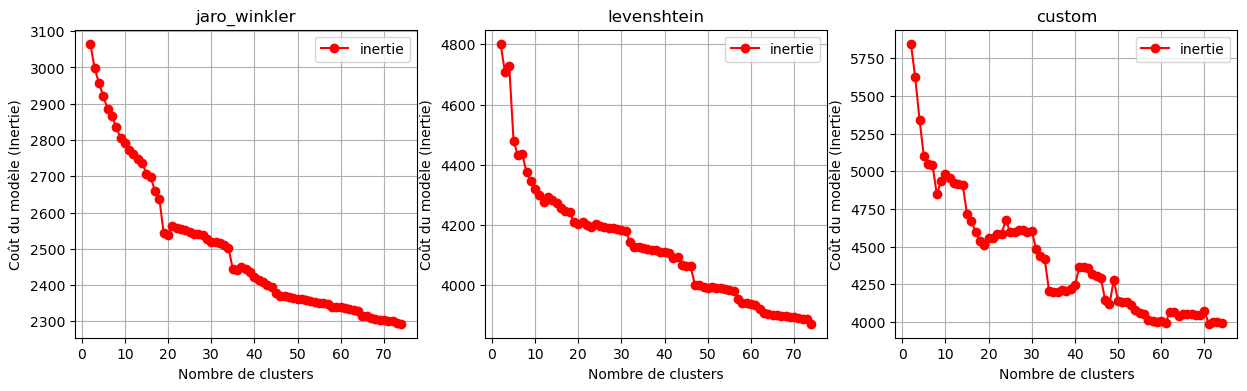

In [32]:
fig, axs = plt.subplots(1, len(inertia), figsize=(5*len(inertia), 4))
for i, distance in enumerate(inertia.keys()):
    ax = axs[i]
    ax.plot(range(2, len(inertia[distance])+2), inertia[distance], c = 'r', label = 'inertie', marker='o')
    ax.legend(loc='best')
    ax.grid('on')
    ax.set_xlabel('Nombre de clusters')
    ax.set_ylabel('Coût du modèle (Inertie)')
    ax.set_title(distance)
plt.show()

In [33]:
for distance in inertia.keys():
    k_elbow = KneeLocator(
      x=range(2, nb_clusters_max), 
      y=inertia[distance], 
      curve="convex", 
      direction="decreasing").elbow
    print(f"distance: {distance} --> nb clusters par méthode du coude = {k_elbow}")

distance: jaro_winkler --> nb clusters par méthode du coude = 19
distance: levenshtein --> nb clusters par méthode du coude = 3
distance: custom --> nb clusters par méthode du coude = 8


### BIC et Silhouette Scores

D'après ce papier: https://arxiv.org/abs/2212.12189 </br>
et ce code (https://github.com/smazzanti/are_you_still_using_elbow_method/blob/main/are-you-still-using-elbow-method.ipynb) qui compare plusieurs méthodes (Coude, Silhouette, Davies-Bouldin, Calinski-Harabasz, BIC), </br>
utiliser la méthode du coude n'est pas la meilleure option; il faut plutôt chercher à maximiser le score BIC, ou maximiser la silhouette (BIC donne des résultats très légèrement meilleurs). 

Tout est résumé ici: https://towardsdatascience.com/are-you-still-using-the-elbow-method-5d271b3063bd

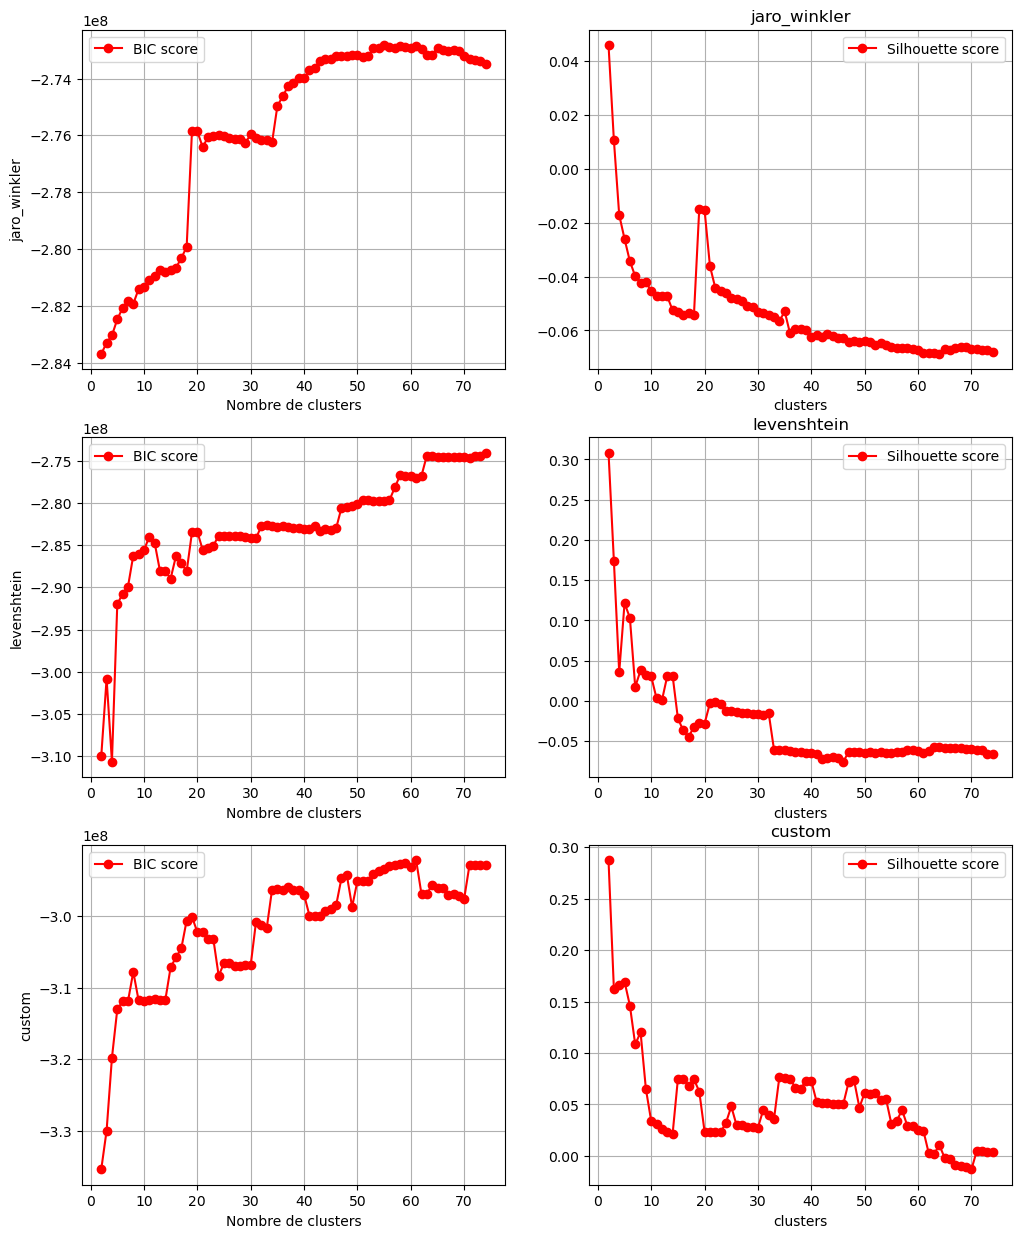

In [34]:
fig, axs = plt.subplots(len(silhouette_scores), 2, figsize=(12, 5*len(silhouette_scores)))

for i, distance in enumerate(silhouette_scores.keys()):
    ax = axs[i]
    #plot bic score
    ax[0].plot(range(2, len(bic_scores[distance])+2), bic_scores[distance], c = 'r', 
               label = 'BIC score', marker='o')
    ax[0].legend(loc='best')
    ax[0].grid('on')
    ax[0].set_xlabel('Nombre de clusters')
    ax[0].set_ylabel(distance)
    #ax[0].set_title('BIC score en fonction du nombre de clusters')

    #plot silhouette scores
    ax[1].plot(range(2, len(silhouette_scores[distance])+2), silhouette_scores[distance], c = 'r', 
               label = 'Silhouette score', marker='o')
    ax[1].legend(loc='best')
    ax[1].grid('on')
    ax[1].set_xlabel('clusters')
    ax[1].set_title(distance)
    #ax[1].set_title('Silhouette score en fonction du nombre de clusters')

plt.show()

In [35]:
for distance in silhouette_scores.keys():
    k_elbow_sil = KneeLocator(
      x=range(2, nb_clusters_max), 
      y=silhouette_scores[distance], 
      curve="convex", 
      direction="decreasing").elbow
    k_elbow_bic = KneeLocator(
      x=range(2, nb_clusters_max), 
      y=bic_scores[distance], 
      curve="concave", 
      direction="increasing").elbow
    
    print(f"distance: {distance} --> nb clusters par BIC        = {k_elbow_bic}")
    print(f"distance: {distance} --> nb clusters par silhouette = {k_elbow_sil}\n")

distance: jaro_winkler --> nb clusters par BIC        = 7
distance: jaro_winkler --> nb clusters par silhouette = 8

distance: levenshtein --> nb clusters par BIC        = 3
distance: levenshtein --> nb clusters par silhouette = 4

distance: custom --> nb clusters par BIC        = 6
distance: custom --> nb clusters par silhouette = 3



# Implement K-Medoids

In [ ]:
n_clusters = 50

In [ ]:
distances = dict_distances['custom']

In [56]:
kmedoids = KMedoids(n_clusters=n_clusters, metric='precomputed')
kmedoids.fit(distances)

KMedoids(metric='precomputed', n_clusters=50)

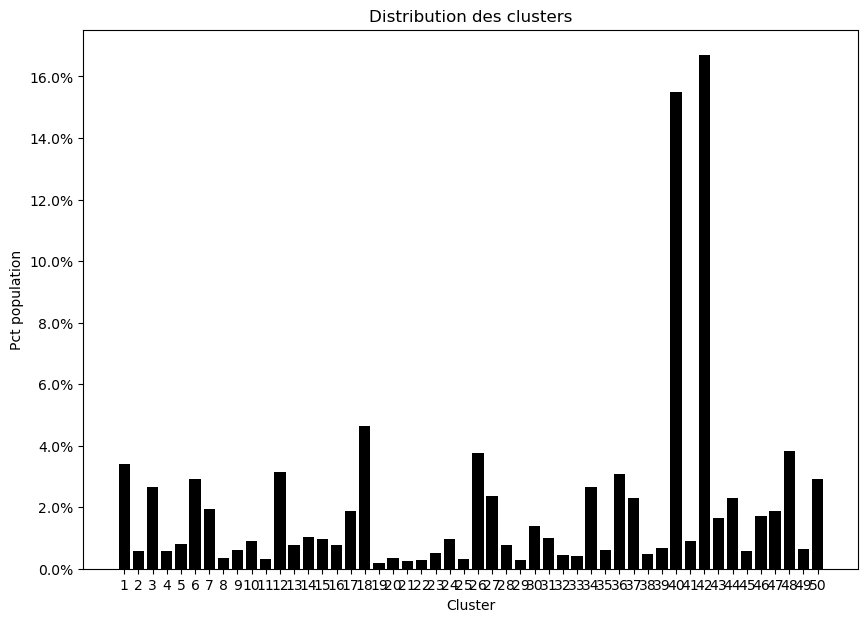

In [57]:
plt.figure(figsize=(10,7))
labels, counts = np.unique(kmedoids.labels_, return_counts=True)
counts = counts / len(kmedoids.labels_)
plt.bar(labels+1, counts, align='center', color = 'black')
plt.gca().set_xticks(labels+1)
plt.gca().yaxis.set_major_formatter(PercentFormatter(1))
plt.title('Distribution des clusters')
plt.xlabel("Cluster")
plt.ylabel('Pct population')
plt.show()

##### Ajout des clusters dans la base

In [58]:
base_patient_cluster = base_patient.drop(columns=["cluster"])

In [59]:
for i in range(1, n_clusters+1):
    base_patient_cluster["cluster"+str(i)] = [0]*len(base_patient_cluster)

In [60]:
for i, label in enumerate(kmedoids.labels_):
    base_patient_cluster.loc[i, "cluster"+str(label+1)] = 1

##### Ajout d'une colonne contenant les parcours de soins

In [61]:
base_patient_cluster['p_soins'] = ['']*len(base_patient_cluster)

In [62]:
for i, patient in enumerate(X_patient):
    p_soin = convert_to_sentence(patient)
    base_patient_cluster.loc[i, 'p_soins'] = p_soin

In [63]:
base_patient_cluster

,CODE_PATIENT,date_h0,y_nais,BEN_RES_DPT,BEN_SEX_COD,dte_deces,Mort,Nb_survie,Nb_hospit,CHOC,...,cluster42,cluster43,cluster44,cluster45,cluster46,cluster47,cluster48,cluster49,cluster50,p_soins
0,P0,2011,1949,11,0,NaN,0,2596,9,0,...,1,0,0,0,0,0,0,0,0,"05K051,05M042,05M16T,05M09T,05M092,05C191,05M2..."
1,P6,2013,1929,14,1,2015-03,1,456,8,0,...,0,0,0,0,0,0,0,0,0,"02C05J,02C05J,05M093,04M132,05C222,23M103,04M0..."
2,P8,2015,1967,54,1,2015-08,1,41,3,1,...,0,0,0,0,0,0,0,0,0,"11M041,06C194"
3,P13,2011,1959,974,0,NaN,0,2783,2,0,...,0,0,0,0,0,0,0,0,0,"05M04T,05K051"
4,P16,2010,1947,76,0,NaN,0,3210,9,0,...,1,0,0,0,0,0,0,0,0,"08C11V,23M15Z,05K102,05M08T,05K102,05C191,23M1..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10046,P24302,2014,1920,29,0,2014-12,1,318,8,0,...,0,0,0,0,0,0,0,0,0,"04M05V,23M20T,05M082,06M033,09M031,05M093,10M1..."
10047,P24303,2012,1927,61,0,2017-05,1,1924,12,0,...,1,0,0,0,0,0,0,0,0,"05M094,05M09T,05K052,23M101,09M053,05C143,23M1..."
10048,P24304,2010,1924,999,0,2010-08,1,5,1,0,...,0,0,0,0,0,0,0,0,0,05M082
10049,P24308,2011,1925,13,1,2013-03,1,484,7,0,...,0,0,0,0,0,0,1,0,0,"05M091,04M173,04M171,04C042,23M061,07M023,04M174"


In [64]:
base_patient_cluster.to_csv("../data/custom_metric/50cluster_50_10_1.csv", index=False)

In [65]:
medoid_indices = kmedoids.medoid_indices_

In [66]:
with open('../data/custom_metric/50cluster_medoids_50_10_1.npy', 'wb') as f:
    np.save(f, medoid_indices)